## Fit the BAO signal

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from cosmoprimo.fiducial import DESI, AbacusSummit
from pycorr import TwoPointCorrelationFunction, project_to_multipoles, project_to_wp
from desilike.profilers import MinuitProfiler
from desilike.samples.profiles import Profiles
from desilike.samplers.emcee import EmceeSampler
from desilike.samples import plotting, Chain
from desilike import setup_logging
setup_logging()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX
from fit_cubic_tools import get_observable_likelihood, load_bins, load_mock_cov
%load_ext autoreload
%autoreload 2

Z_VSMEAR = REDSHIFT_LSS_VSMEAR
Z_CUBIC = REDSHIFT_LSS_CUBICBOX
base_dir = '/pscratch/sd/s/shengyu/results/cubic'

Loading exist EZmocks covariance


[000270.18] [0/1] 04-01 02:32  TracerCorrelationFunctionMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.6-0.8/AbacusSummit_base_c000_ph021/mpspk/xipoles_LRG_z0.6-0.8_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.6-0.8/AbacusSummit_base_c000_ph017/mpspk/xipoles_LRG_z0.6-0.8_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.6-0.8/AbacusSummit_base_c000_ph019/mpspk/xipoles_LRG_z0.6-0.8_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.6-0.8/AbacusSummit_base_c000_ph020/mpspk/xipoles_LRG_z0.6-0.8_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.6-0.8/AbacusSummit_base_c000_ph012/mpspk/xipoles_LRG_z0.6-0.8_standard.npy].
[000270.27] [0/1] 04-01 02:32  numexpr.utils      

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


-16.30015231545064
[000274.52] [0/1] 04-01 02:32  MinuitProfiler            INFO     Varied parameters: ['qiso', 'qap', 'b1', 'dbeta', 'sigmas', 'sigmapar', 'sigmaper', 'al2_0', 'al2_1', 'bl0_0', 'bl0_2', 'bl2_0', 'bl2_2'].
[000275.63] [0/1] 04-01 02:32  MinuitProfiler            INFO     Successfully jit input likelihood.
+-------------------------------------+--------+---------+---------+
| chi2 / (46 - 13) = 9.77 / 33 = 0.30 | varied | bestfit |  error  |
+-------------------------------------+--------+---------+---------+
|                qiso                 |  True  | 0.9995  | 0.0083  |
|                 qap                 |  True  |  0.997  |  0.030  |
|                 b1                  |  True  |  1.657  |  0.081  |
|                dbeta                |  True  |  1.30   |  0.51   |
|               sigmas                |  True  |  2.16   |  0.96   |
|              sigmapar               |  True  |  7.33   |  0.65   |
|              sigmaper               |  True  |  3.59

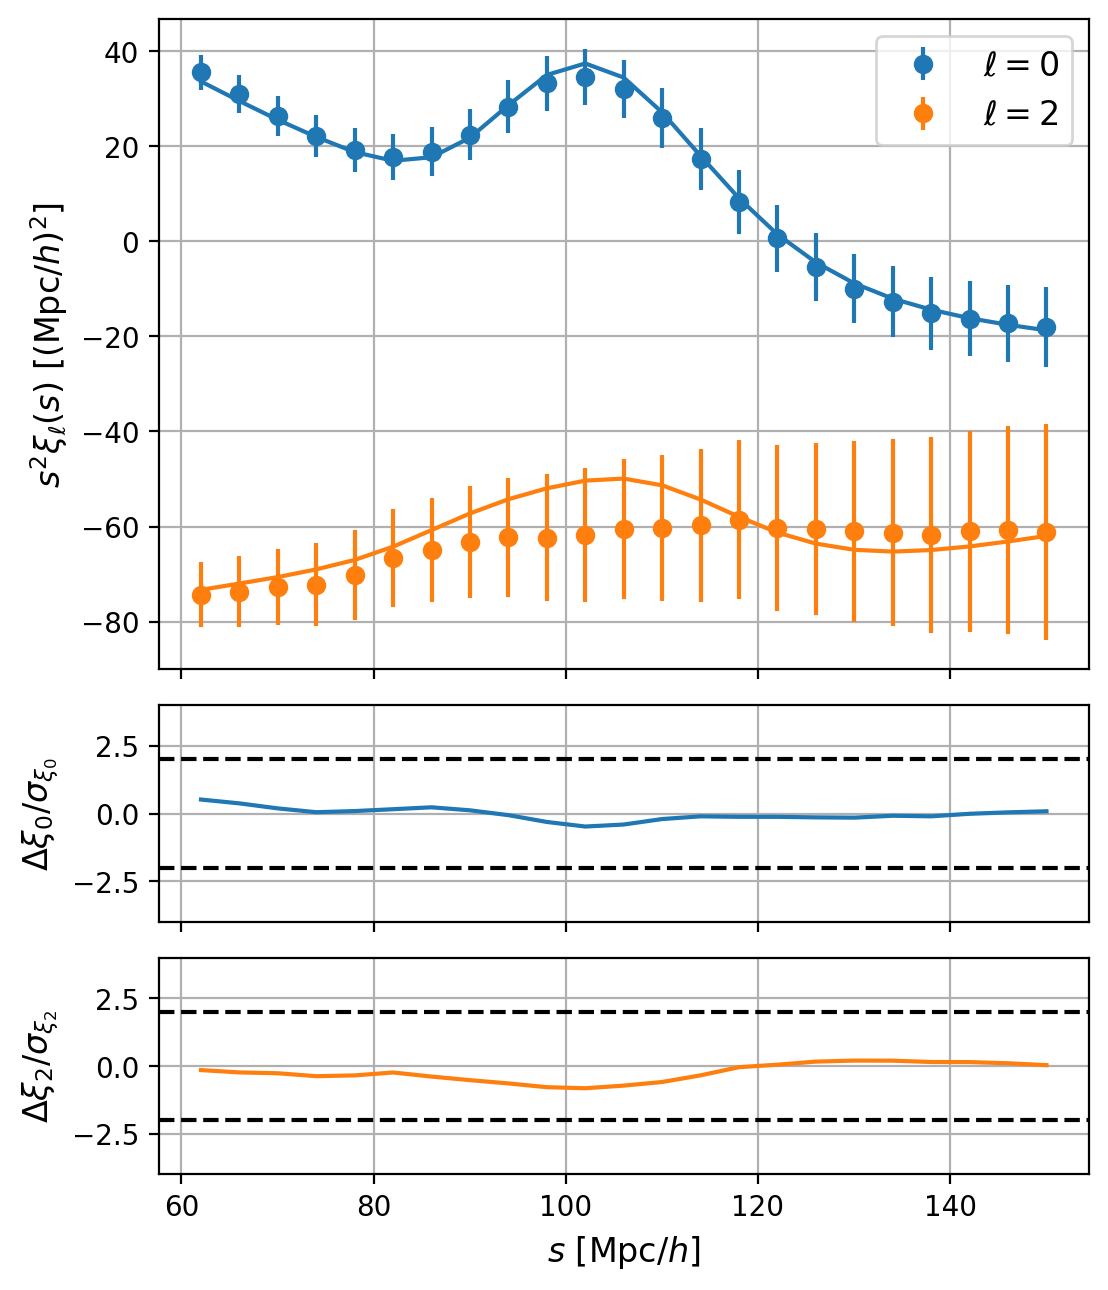

In [5]:
task = 'BAOfit_cubic_sys'
cov_type = 'covbox' # covbox, rescalC

tracer = 'LRG'
sys_model = 'standard'
(zmin, zmax) = REDSHIFT_VSMEAR[tracer][1]
z_eff = REDSHIFT_CUBICBOX[tracer][1]
recon  = False

data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "recon": recon, "sys_model": sys_model, "grid_cosmo": "000"}
fit_args = {"corr_type": 'xi', "bins_type": 'y3_sys', "cov_type": 'cov_fn', "recon": recon}
(likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
print(likelihood())
profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize()
print(profiles.to_stats(tablefmt='pretty'))
print(likelihood(**profiles.bestfit.choice(input=True)))
fig = observable.plot()

In [13]:
(observable.s[0])

array([ 62.04198155,  66.03986634,  70.03763961,  74.03558115,
        78.03392653,  82.03238672,  86.03107565,  90.02968179,
        94.02843812,  98.0271485 , 102.02605199, 106.02494943,
       110.0240763 , 114.02318105, 118.02247118, 122.02172273,
       126.02095139, 130.02045731, 134.01987867, 138.01930374,
       142.01874108, 146.01828022, 150.01777019])

In [13]:
# MCMC sampling
nwalkers = 64 
interations = 3001 # save every 300 iterations
chain_fn = './result/chain_test.npy'
sampler = EmceeSampler(likelihood, seed=40, nwalkers=nwalkers, save_fn = chain_fn)
sampler.run(check={'max_eigen_gr': 0.005}, max_iterations = interations) # save every 300 iterations

[000036.76] [0/1] 03-01 02:08  EmceeSampler              INFO     Varied parameters: ['qiso', 'b1', 'sigmas', 'sigmapar', 'sigmaper', 'bl0_0', 'bl0_2'].


[000037.18] [0/1] 03-01 02:08  EmceeSampler              INFO     Successfully vmap input likelihood.
[000037.96] [0/1] 03-01 02:08  EmceeSampler              INFO     Successfully jit input likelihood.
[000038.95] [0/1] 03-01 02:08  TaskManager               INFO     Entering TaskManager with 1 workers.
[000062.45] [0/1] 03-01 02:08  Chain                     INFO     Saving ./result/chain_test.npy.
[000062.46] [0/1] 03-01 02:08  EmceeSampler              INFO     Diagnostics:
[000062.48] [0/1] 03-01 02:08  Diagnostics               INFO     - max eigen Gelman-Rubin - 1 is 0.264; not < 0.1.
[000062.50] [0/1] 03-01 02:08  Diagnostics               INFO     - max diag Gelman-Rubin - 1 is 0.157.
[000062.58] [0/1] 03-01 02:08  Diagnostics               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.441.
[000062.60] [0/1] 03-01 02:08  Diagnostics               INFO     - max Geweke is 0.229.
[000062.60] [0/1] 03-01 02:08  Diagnostics               INFO     - Geweke p-value is 0.00

Traceback (most recent call last):
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/samplers/base.py", line 61, in wrapper
    toret[mask] = func(self, values)
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/samplers/base.py", line 151, in logposterior
    results = self._vlikelihood(points.to_dict())
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/samplers/base.py", line 264, in _vlikelihood
    return vlikelihood(*args, **kwargs, mpicomm=self.mpicomm)
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/base.py", line 324, in wrapper
    states = calculate(chunk_params, **kw)
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/para

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
from plotting_tools import plot_mcmc_walkers, plot_mcmc_contour
chain_fn = './result/chain_test.npy'
chain = Chain.load(chain_fn).remove_burnin()[::]
plot_mcmc_walkers(chain, params= ['qiso', 'qap', 'b1'])
print(chain.to_stats(tablefmt='pretty'))

[000201.11] [0/1] 03-01 01:39  Chain                     INFO     Loading ./result/chain_test.npy.


+----------+---------+---------+---------+---------+-----------------+-----------------+
|          | argmax  |  mean   | median  |   std   | quantile:1sigma | interval:1sigma |
+----------+---------+---------+---------+---------+-----------------+-----------------+
|   qiso   | 0.9983  | 0.9990  | 0.9990  | 0.0045  | -0.0042/+0.0044 | -0.0040/+0.0045 |
|   qap    |  0.994  |  0.997  |  0.997  |  0.015  |  -0.015/+0.014  |  -0.014/+0.015  |
|    b1    |  1.982  |  1.951  |  1.950  |  0.082  |  -0.082/+0.082  |  -0.089/+0.073  |
|  dbeta   |  1.00   |  0.99   |  0.99   |  0.17   |   -0.20/+0.20   |   -0.24/+0.16   |
|  sigmas  |   2.5   |   3.6   |   3.1   |   2.7   |    -2.9/+3.2    |    -3.6/+1.2    |
| sigmapar |   6.9   |   7.0   |   7.5   |   2.7   |   -0.81/+1.52   |   -0.70/+1.62   |
| sigmaper |   3.5   |   0.7   |   1.8   |   3.2   |    -4.1/+3.3    |    -3.2/+3.9    |
|  al2_0   |   -22   |    4    |    4    |   39    |    -40./+40.    |    -40./+40.    |
|  al2_1   |   0.0   

In [7]:
chain_fn = './result/chain_test.npy'
burnin=  0.60
slice_step = 60

chain_fn = './result/chain_test.npy'
chain = Chain.load(chain_fn).remove_burnin(burnin)[::slice_step]
plot_mcmc_contour(chain, params= ['qiso', 'qap', 'b1'])

[000203.00] [0/1] 03-01 01:39  Chain                     INFO     Loading ./result/chain_test.npy.


Removed no burn in


In [5]:
task = 'fitbao_recon_cubic_sys'
bins_type = 'y3_bao' # test, y3_bao

tracers = ['LRG','ELG','QSO']
sys_models = ['standard', 'dv-obs']
recon  = True
nwalkers = 64
interations = 6001 # save every 300 iterations

for tracer in tracers:
    for z_eff, (zmin, zmax) in zip(REDSHIFT_CUBICBOX[tracer], REDSHIFT_VSMEAR[tracer]):
        for sys_model in sys_models:
            data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, 
                        'corr':'xi', "recon": recon, "sys_model": sys_model, "grid_cosmo": "000"}
            chain_fn = f'./result/baofit/chain_recon_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npy'
            if not os.path.exists(chain_fn):
                observable, likelihood = set_bao_likelihood(task, data_args, bins_type)
                # MCMC sampling
                sampler = EmceeSampler(likelihood, seed=40, nwalkers=nwalkers, save_fn = chain_fn)
                sampler.run(check={'max_eigen_gr': 0.1}, max_iterations = interations) # save every 300 iterations

sys here
LRG 0.4 0.6 True 000 standard
[000011.55]  03-02 06:46  TracerCorrelationFunctionMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph021/mpspk/xipoles_recon_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph017/mpspk/xipoles_recon_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph019/mpspk/xipoles_recon_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph020/mpspk/xipoles_recon_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph012/mpspk/xipoles_recon_LRG_z0.4-0.6_s

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000015.38]  03-02 06:46  EmceeSampler                 INFO     Varied parameters: ['qiso', 'qap', 'b1', 'dbeta', 'sigmas', 'sigmapar', 'sigmaper', 'al2_0', 'al2_1', 'bl0_0', 'bl0_2', 'bl2_0', 'bl2_2'].
[000016.72]  03-02 06:46  EmceeSampler                 INFO     Successfully vmap input likelihood.
[000017.60]  03-02 06:46  EmceeSampler                 INFO     Successfully jit input likelihood.
[000018.79]  03-02 06:46  TaskManager                  INFO     Entering TaskManager with 1 workers.
[000047.73]  03-02 06:46  Chain                        INFO     Saving ./result/baofit/chain_recon_LRG_z0.4-0.6_standard.npy.
[000047.75]  03-02 06:46  EmceeSampler                 INFO     Diagnostics:
[000047.79]  03-02 06:46  Diagnostics                  INFO     - max eigen Gelman-Rubin - 1 is 0.266; not < 0.1.
[000047.84]  03-02 06:46  Diagnostics                  INFO     - max diag Gelman-Rubin - 1 is 0.0812.
[000048.00]  03-02 06:46  Diagnostics                  INFO     - max diag Ge

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000256.90]  03-02 06:50  EmceeSampler                 INFO     Varied parameters: ['qiso', 'qap', 'b1', 'dbeta', 'sigmas', 'sigmapar', 'sigmaper', 'al2_0', 'al2_1', 'bl0_0', 'bl0_2', 'bl2_0', 'bl2_2'].
[000257.35]  03-02 06:50  EmceeSampler                 INFO     Successfully vmap input likelihood.
[000258.24]  03-02 06:50  EmceeSampler                 INFO     Successfully jit input likelihood.
[000259.40]  03-02 06:50  TaskManager                  INFO     Entering TaskManager with 1 workers.
[000285.26]  03-02 06:50  Chain                        INFO     Saving ./result/baofit/chain_recon_LRG_z0.4-0.6_dv-obs.npy.
[000285.27]  03-02 06:50  EmceeSampler                 INFO     Diagnostics:
[000285.31]  03-02 06:50  Diagnostics                  INFO     - max eigen Gelman-Rubin - 1 is 0.277; not < 0.1.
[000285.35]  03-02 06:50  Diagnostics                  INFO     - max diag Gelman-Rubin - 1 is 0.079.
[000285.51]  03-02 06:50  Diagnostics                  INFO     - max diag Gelma

KeyboardInterrupt: 